# Libraries

In [1]:
from  google.colab  import  drive 
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import scipy
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics.pairwise as pw
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import random
from scipy import sparse
from scipy.stats import pearsonr
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
import torch
from torchtext import data
from torchtext import datasets

# Pre-Processing

In [3]:

df = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/To Do Reviews/reviews_with_emotions_from_title.csv')
del df['ActivityId']
del df['Unnamed: 0']
df = df.reindex(columns=['UserId', 'Name', 'ReviewTitle', 'Review', 'EmotionFromTitle'])
df.head()

,UserId,Name,ReviewTitle,Review,EmotionFromTitle
0,1,acropolis,Acropolis - Breathtaking,What an experience. I highly recommend doing t...,admiration
1,2,acropolis,Crowded but fabulous,Been there back in 1989 when you could walk an...,admiration
2,3,acropolis,You can't go to Athens and fail to visit the A...,The Acropolis is actually the name of the hill...,neutral
3,4,acropolis,A must see,You can’t visit Athens without visiting the Ac...,neutral
4,5,acropolis,Awesome place.,"Visited in late september, early october (pere...",admiration


In [5]:
df['Review']=df['Review'].str.lower()
df['ReviewTitle']=df['ReviewTitle'].str.lower()

In [6]:
df['Review']

0        what an experience. i highly recommend doing t...
1        been there back in 1989 when you could walk an...
2        the acropolis is actually the name of the hill...
3        you can’t visit athens without visiting the ac...
4        visited in late september, early october (pere...
                               ...                        
11991    this is by far my favourite part of athens. th...
11992    if you are visiting athens it would be a crime...
11993    i went here for a day of shopping and it was f...
11994    very interesting area with lovely choices of m...
11995    excellent area for walking, shopping, eating a...
Name: Review, Length: 11996, dtype: object

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def remove_punctuation(text):
    #η συνάρτηση χωρίζει τις λέξεις σε γράμματα, αφαιρεί σημεία στίξης και συγκεντρώνει ξανά γράμματα ως λέξεις
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [10]:
df['Review_Clean'] = df['Review'].apply(lambda x: remove_punctuation(x))
df['Title_Clean'] = df['ReviewTitle'].apply(lambda x: remove_punctuation(x))
df.head()

,UserId,Name,ReviewTitle,Review,EmotionFromTitle,Review_Clean,Title_Clean
0,1,acropolis,acropolis - breathtaking,what an experience. i highly recommend doing t...,admiration,what an experience i highly recommend doing th...,acropolis breathtaking
1,2,acropolis,crowded but fabulous,been there back in 1989 when you could walk an...,admiration,been there back in 1989 when you could walk an...,crowded but fabulous
2,3,acropolis,you can't go to athens and fail to visit the a...,the acropolis is actually the name of the hill...,neutral,the acropolis is actually the name of the hill...,you cant go to athens and fail to visit the ac...
3,4,acropolis,a must see,you can’t visit athens without visiting the ac...,neutral,you can’t visit athens without visiting the ac...,a must see
4,5,acropolis,awesome place.,"visited in late september, early october (pere...",admiration,visited in late september early october perect...,awesome place


In [11]:
stop_words = set(STOPWORDS)

In [12]:
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500, max_font_size = 100, random_state = 42, width=800, height=400)

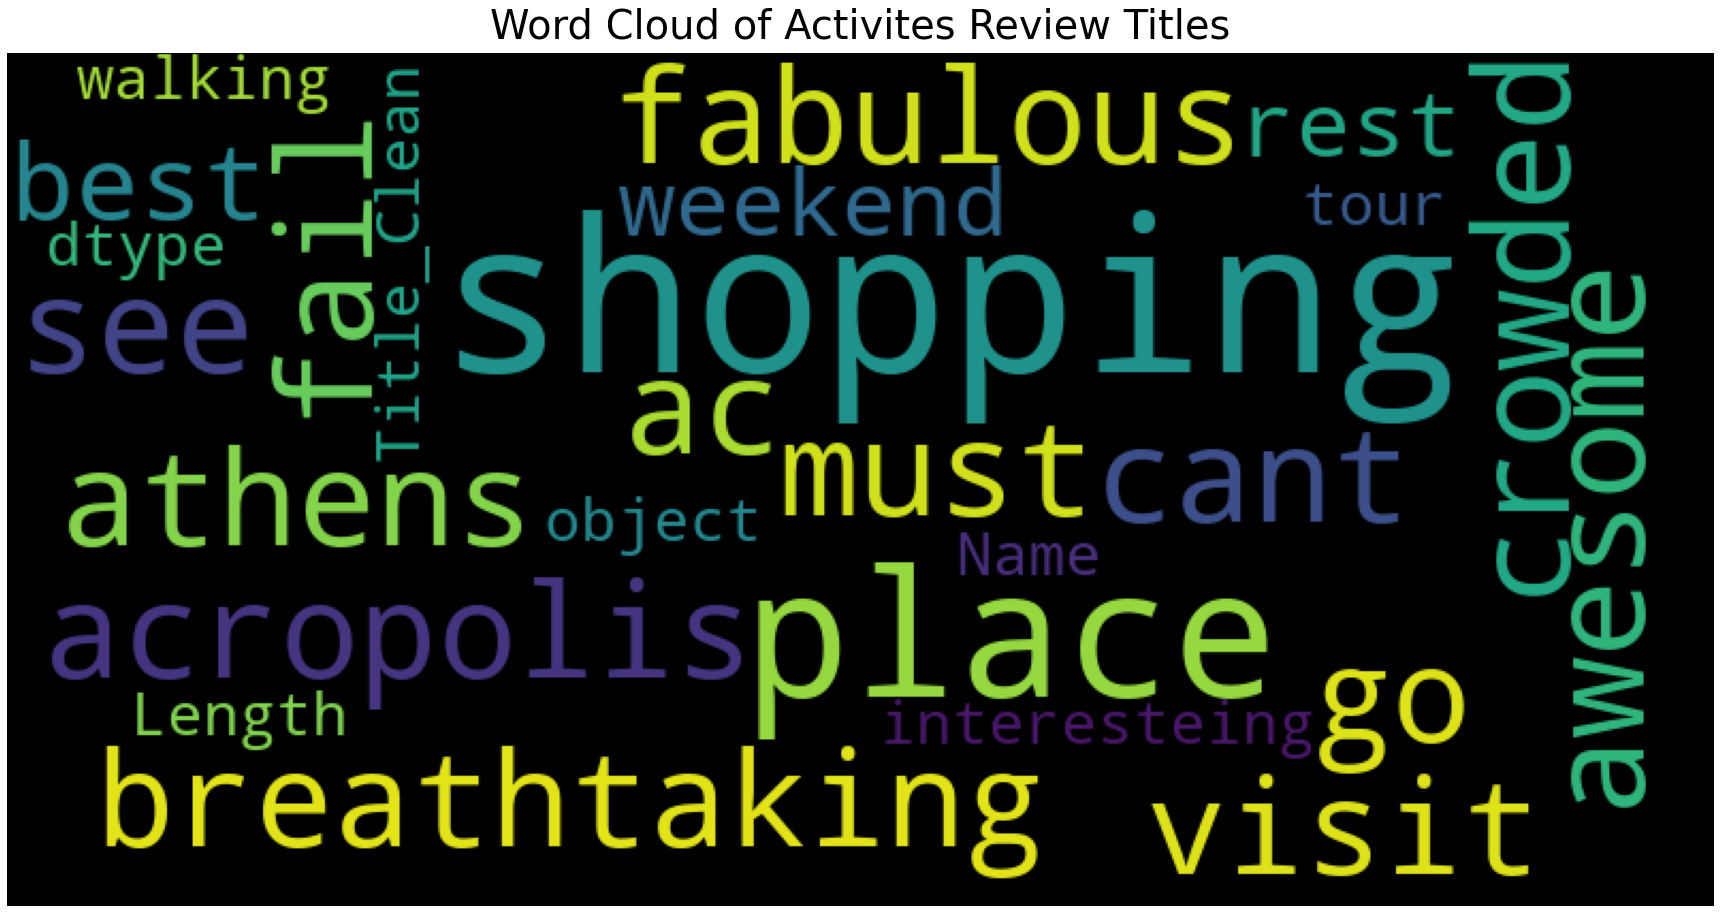

In [15]:
wordcloud.generate(str(df['Title_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Activites Review Titles", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

Τα wordclouds δίνουν μια γενική ιδέα για το τι είναι κείμενο, αλλά χρειάζονται πιο χαρακτηριστικές λέξεις επειδή όλες οι λέξεις δεν βρίσκονται στο ίδιο κείμενο σε αυτά τα δεδομένα.

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
def word_count(reviews):
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

25 πιο κοινές λέξεις στους τίτλους

In [19]:
word_frequency=word_count(df['Title_Clean'])

In [24]:
df_count = pd.DataFrame(columns=['word', 'count'])
df_count['word'] = word_frequency.keys()
df_count['count'] = list(word_frequency.values())
df_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_count=df_pos_count.reset_index(drop=True)

In [25]:
stop_words = set(STOPWORDS)

In [26]:
stop = set(stopwords.words("english"))

Θα δημιουργήσω νέα στήλη ως word_without_stop και θα κάνουμε drop τη σειρά εάν περιέχει ενδιάμεσες λέξεις.

In [27]:
df_count['word_without_stop'] = df_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [29]:
df_without_stop = df_count.dropna(subset=['word_without_stop'])

In [30]:
df_top_25 = df_count.loc[df_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


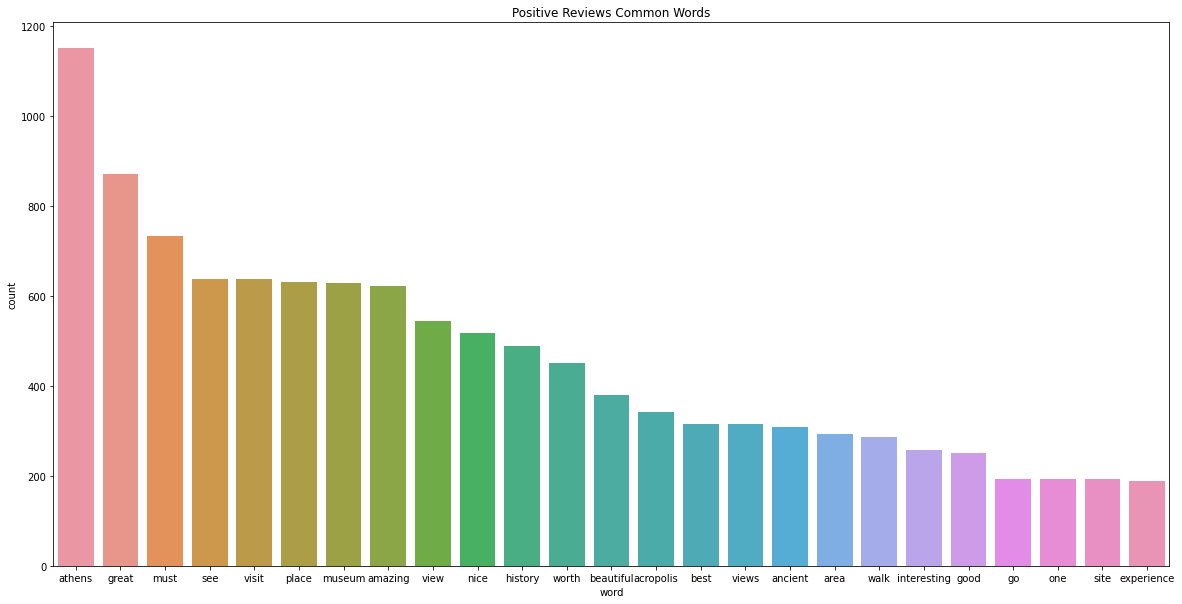

In [31]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot("word","count", data=df_top_25)

In [32]:
df

,UserId,Name,ReviewTitle,Review,EmotionFromTitle,Review_Clean,Title_Clean
0,1,acropolis,acropolis - breathtaking,what an experience. i highly recommend doing t...,admiration,what an experience i highly recommend doing th...,acropolis breathtaking
1,2,acropolis,crowded but fabulous,been there back in 1989 when you could walk an...,admiration,been there back in 1989 when you could walk an...,crowded but fabulous
2,3,acropolis,you can't go to athens and fail to visit the a...,the acropolis is actually the name of the hill...,neutral,the acropolis is actually the name of the hill...,you cant go to athens and fail to visit the ac...
3,4,acropolis,a must see,you can’t visit athens without visiting the ac...,neutral,you can’t visit athens without visiting the ac...,a must see
4,5,acropolis,awesome place.,"visited in late september, early october (pere...",admiration,visited in late september early october perect...,awesome place
...,...,...,...,...,...,...,...
11991,1446,plaka,best place for shopping,this is by far my favourite part of athens. th...,admiration,this is by far my favourite part of athens the...,best place for shopping
11992,1447,plaka,a weekend of rest,if you are visiting athens it would be a crime...,relief,if you are visiting athens it would be a crime...,a weekend of rest
11993,1448,plaka,shopping and more shopping,i went here for a day of shopping and it was f...,neutral,i went here for a day of shopping and it was f...,shopping and more shopping
11994,1449,plaka,interesteing,very interesting area with lovely choices of m...,excitement,very interesting area with lovely choices of m...,interesteing


In [33]:
df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/To Do Reviews/cleaned_data.csv', index = False)

In [34]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε χρήστη
df['Reviewer_Count'] = df['UserId'].map(df['UserId'].value_counts())

In [35]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε εστιατορείου
df['Activity_Count'] = df['Name'].map(df['Name'].value_counts())

In [36]:
df = df.sort_values(by=['Reviewer_Count'],ascending=False)

In [37]:
df

,UserId,Name,ReviewTitle,Review,EmotionFromTitle,Review_Clean,Title_Clean,Reviewer_Count,Activity_Count
0,1,acropolis,acropolis - breathtaking,what an experience. i highly recommend doing t...,admiration,what an experience i highly recommend doing th...,acropolis breathtaking,11,1500
5837,662,mount lycabettus,one of the top places to view athens,"incredible views, but it's not a must-see unle...",admiration,incredible views but its not a mustsee unless ...,one of the top places to view athens,11,1250
5835,660,mount lycabettus,give it a miss honestly! not worth it!,this place wasn't on my list it was only until...,disapproval,this place wasnt on my list it was only until ...,give it a miss honestly not worth it,11,1250
5834,659,mount lycabettus,nice view,"we went to lycabettus hill by foot, it is a go...",admiration,we went to lycabettus hill by foot it is a goo...,nice view,11,1250
5833,658,mount lycabettus,great hike with a stunning view of athens,"it is worth it to hike up the hill, when you g...",admiration,it is worth it to hike up the hill when you go...,great hike with a stunning view of athens,11,1250
...,...,...,...,...,...,...,...,...,...
1477,1478,acropolis,don't miss this,you would be forgiven for thinking you could s...,caring,you would be forgiven for thinking you could s...,dont miss this,1,1500
1478,1479,acropolis,"obviously a ""must see""","impressed to be in this world heritage site, a...",approval,impressed to be in this world heritage site al...,obviously a must see,1,1500
1479,1480,acropolis,magical acropolis,i visit the acropolis every time i come to ath...,admiration,i visit the acropolis every time i come to ath...,magical acropolis,1,1500
1480,1481,acropolis,ancient greek remains,"a ""must see"" tourist spot in athens. acropolis...",neutral,a must see tourist spot in athens acropolis is...,ancient greek remains,1,1500


In [38]:
df.reset_index(drop=True,inplace=True) 

In [39]:
df.isna().sum()

UserId              0
Name                0
ReviewTitle         0
Review              0
EmotionFromTitle    0
Review_Clean        0
Title_Clean         0
Reviewer_Count      0
Activity_Count      0
dtype: int64

# Recommendations from Keywords

## Recommending based on cosine similarity of reviews

In [40]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import math
from collections import Counter
import operator

In [41]:
stop = set(stopwords.words("english")) #σετάρουμε τα stopwords

In [42]:
df

,UserId,Name,ReviewTitle,Review,EmotionFromTitle,Review_Clean,Title_Clean,Reviewer_Count,Activity_Count
0,1,acropolis,acropolis - breathtaking,what an experience. i highly recommend doing t...,admiration,what an experience i highly recommend doing th...,acropolis breathtaking,11,1500
1,662,mount lycabettus,one of the top places to view athens,"incredible views, but it's not a must-see unle...",admiration,incredible views but its not a mustsee unless ...,one of the top places to view athens,11,1250
2,660,mount lycabettus,give it a miss honestly! not worth it!,this place wasn't on my list it was only until...,disapproval,this place wasnt on my list it was only until ...,give it a miss honestly not worth it,11,1250
3,659,mount lycabettus,nice view,"we went to lycabettus hill by foot, it is a go...",admiration,we went to lycabettus hill by foot it is a goo...,nice view,11,1250
4,658,mount lycabettus,great hike with a stunning view of athens,"it is worth it to hike up the hill, when you g...",admiration,it is worth it to hike up the hill when you go...,great hike with a stunning view of athens,11,1250
...,...,...,...,...,...,...,...,...,...
11991,1478,acropolis,don't miss this,you would be forgiven for thinking you could s...,caring,you would be forgiven for thinking you could s...,dont miss this,1,1500
11992,1479,acropolis,"obviously a ""must see""","impressed to be in this world heritage site, a...",approval,impressed to be in this world heritage site al...,obviously a must see,1,1500
11993,1480,acropolis,magical acropolis,i visit the acropolis every time i come to ath...,admiration,i visit the acropolis every time i come to ath...,magical acropolis,1,1500
11994,1481,acropolis,ancient greek remains,"a ""must see"" tourist spot in athens. acropolis...",neutral,a must see tourist spot in athens acropolis is...,ancient greek remains,1,1500


In [43]:
df['word_without_stop'] = df['Title_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [44]:
def cosine_similarity_of(text1, text2):
        
        # διαβάζουμε τις λέξεις
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        # δημιουργεία λεξιλογίου
        vector1 = Counter(first)
        vector2 = Counter(second)

        # αλλάζοντας διανύσματα σε σύνολα για να βρούμε κοινές λέξεις με τομή
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
          
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        # άθροισμα των μετρήσεων λέξεων για κάθε διάνυσμα
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        # υπολογισμός του μεγέθους του διανύσματος με άθροισμα τετραγώνων
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [45]:
text1 = df['word_without_stop'][1] 
text2 = df['word_without_stop'][2] 
cosine_similarity_of(text1, text2)

0.0

In [46]:
def get_recommendations(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            score_dict[index] = cosine_similarity_of(row['word_without_stop'], keywords)

        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similarities
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('UserId', 'Name','word_without_stop', 'score'))

        # κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
            result = result.append({'UserId': df.iloc[i[0]]['UserId'], 
                                        'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break

        return result



In [47]:
keywords = "best place ever"

In [48]:
top_10= get_recommendations(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,UserId,Name,word_without_stop,score
0,349,parthenon,best place world,0.666667
1,75,monastiraki,one best place,0.666667
2,144,panathenaic stadium,best place trip,0.666667
3,353,plaka,best place athens,0.666667
4,88,acropolis,best experience ever,0.666667
5,264,herod,best place concert,0.666667
6,330,mount lycabettus,best,0.577350


In [52]:
df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/To Do Reviews/activities_for_keywords_recommendation.csv', index = False)

In [53]:
df

,UserId,Name,ReviewTitle,Review,EmotionFromTitle,Review_Clean,Title_Clean,Reviewer_Count,Activity_Count,word_without_stop
0,1,acropolis,acropolis - breathtaking,what an experience. i highly recommend doing t...,admiration,what an experience i highly recommend doing th...,acropolis breathtaking,11,1500,acropolis breathtaking
1,662,mount lycabettus,one of the top places to view athens,"incredible views, but it's not a must-see unle...",admiration,incredible views but its not a mustsee unless ...,one of the top places to view athens,11,1250,one top places view athens
2,660,mount lycabettus,give it a miss honestly! not worth it!,this place wasn't on my list it was only until...,disapproval,this place wasnt on my list it was only until ...,give it a miss honestly not worth it,11,1250,give miss honestly worth
3,659,mount lycabettus,nice view,"we went to lycabettus hill by foot, it is a go...",admiration,we went to lycabettus hill by foot it is a goo...,nice view,11,1250,nice view
4,658,mount lycabettus,great hike with a stunning view of athens,"it is worth it to hike up the hill, when you g...",admiration,it is worth it to hike up the hill when you go...,great hike with a stunning view of athens,11,1250,great hike stunning view athens
...,...,...,...,...,...,...,...,...,...,...
11991,1478,acropolis,don't miss this,you would be forgiven for thinking you could s...,caring,you would be forgiven for thinking you could s...,dont miss this,1,1500,dont miss
11992,1479,acropolis,"obviously a ""must see""","impressed to be in this world heritage site, a...",approval,impressed to be in this world heritage site al...,obviously a must see,1,1500,obviously must see
11993,1480,acropolis,magical acropolis,i visit the acropolis every time i come to ath...,admiration,i visit the acropolis every time i come to ath...,magical acropolis,1,1500,magical acropolis
11994,1481,acropolis,ancient greek remains,"a ""must see"" tourist spot in athens. acropolis...",neutral,a must see tourist spot in athens acropolis is...,ancient greek remains,1,1500,ancient greek remains
